In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import plotly.express as ex

from tqdm.cli import tqdm
from glob import glob
from sklearn.manifold import TSNE
from plotly import express as ex
from os import path as pathlib,walk

%matplotlib inline

In [153]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,Callback

In [154]:
class Dataset(object):
    """
    Dataset wrapper to read images from folder and structure it.
    """
    def __init__(self,path,n_faces,resize=128):
        self.path = pathlib.abspath(path)
        self.resize = resize

    def __repr__(self,):
        return f"Dataset Parser @ {self.path}"
        
    def parse(self,progress_bar=True):
        w = walk(self.path)
        self.data = np.array([[[r,pathlib.join(r,f_)] for f_ in f] for r,_,f in list(w)[1:]]).reshape(-1,2)
        self.y = np.array(self.data[:,0])
        self.x = np.array([
            cv2.cvtColor(
                cv2.resize(
                    cv2.imread(
                        i
                    ),
                    (self.resize,self.resize)
                ),
                cv2.COLOR_BGR2RGB
            ) / 255
            for 
                i
            in 
                (tqdm(self.data[:,1]) if progress_bar else self.data[:,1])
        ]).astype(np.float32)
        return self
            

In [155]:
dataset = Dataset("./images/train/",200)

In [156]:
dataset.parse(progress_bar=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1375.67it/s]


Dataset Parser @ C:\workspace\facedet\notebooks\images\train

### Base Network

In [334]:
class LargeTanH(keras.layers.Layer):
    def call(self,x):
        x = tf.math.sigmoid(x)
        x = tf.multiply(x, 8)
        return x

In [368]:
def block(x, filters, kernel_size=3, strides=1, activation='tanh'):
    x = Conv2D(filters,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LargeTanH()(x)
    
    x = DepthwiseConv2D(kernel_size, padding='same', strides=strides)(x)
    x = BatchNormalization()(x)
    x = LargeTanH()(x)
    
    return x
    
def base_network(d=32):
    im_in = Input(shape=(128,128,3))
    
    b1 = block(im_in, 16,strides=2)
    
    b2 = block(b1, 32,)
    b2 = block(b2, 32, strides=2)
    
    b3 = block(b2, 64,)
    b3 = block(b3, 64,)
    b3 = block(b3, 64,)
    
    b4 = block(b3, 128,)
    b4 = block(b4, 128,)
    b4 = block(b4, 128, )
    b4 = block(b4, 128, strides=2)
    
    b5 = block(b4, 256,)
    b5 = block(b5, 256,)
    b5 = block(b5, 256, )
    
    b6 = block(b5, 512,)
    b6 = block(b6, 512, strides=2)
    
    b7 = block(b6, 1024,)
    
    out = GlobalAveragePooling2D()(b7)
    out = Dense(d,use_bias=False,)(out)
    out = BatchNormalization()(out)
    out = LargeTanH()(out)
    
    return keras.Model(im_in,out)


def base_network(d=32):
    
    im_in = keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=( 128, 128, 3))
    
    out = GlobalAveragePooling2D()(im_in.output)
    out = Dense(d, )(out)
    out = LayerNormalization()(out)
    out = Activation('tanh')(out)
    
    return keras.Model( im_in.input, out )    

In [369]:
class Pairs(object):
    def __init__(self,model:tf.keras.Model,x:np.ndarray,y:np.ndarray,size:int=128):
        self.x = x.reshape(-1,size, size,3) 
        self.y = y
        self.dummy = np.array([[0]])
        
        self.model = model
        self.size = size
        
    def generate_pairs(self,):
        pass
    
    def flow(self,):
        while True:
            emb = self.model(self.x)
            score = tf.math.abs(tf.reduce_mean(emb - tf.reshape(emb, shape=(-1, 1, 32)), axis=-1))
            ps = []
            for a,( dy , de ) in enumerate(zip(self.y,score)):
                de = de.numpy()
                p_index, = np.where( yy == dy )
                n_index, = np.where( yy != dy )
                p = p_index[de[p_index].argmax()]
                n = n_index[de[n_index].argmin()]
                ps.append((a,p,n))
            ps = np.array(ps)
            for a,p,n in ps:
                yield ( self.x[a:a+1], self.x[p:p+1], self.x[n:n+1] ), self.dummy            

In [370]:
model = base_network()
pairs = Pairs(model,dataset.x,dataset.y)
flow = pairs.flow()

17227776/17225924 [==============================] - 2s 0us/step


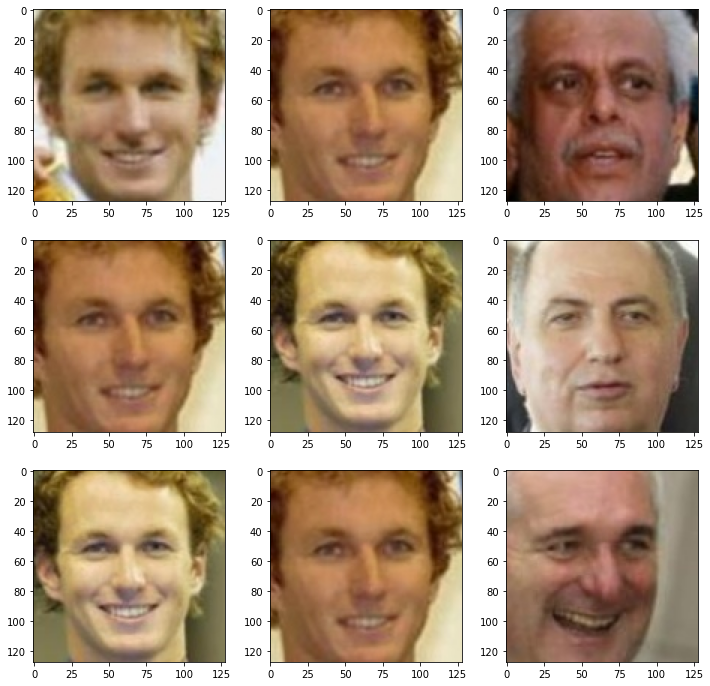

In [371]:
fig,axes = plt.subplots(3,3,figsize=(12,12))

for ax in axes:
    (a,p,n),r = next(flow)
    ax[0].imshow(a.reshape(128, 128 ,3))
    ax[1].imshow(p.reshape(128, 128 ,3))
    ax[2].imshow(n.reshape(128, 128 ,3))

### Triplet Loss

In [372]:
class Triplet(tf.Module):
    """
    Triplet Loss
    """
    __name__ = "TripletLoss"
    def __init__(self,d,margin=.75):
        self.d = d
        self.margin = margin
        self.l2 = keras.losses.MeanAbsoluteError()
 
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        a,p,n = tf.unstack(tf.reshape(y_pred,(3,-1,self.d)))
        
        Dp = self.l2(a,p)
        Dn = self.l2(a,n)
        
        return tf.nn.relu(Dp - Dn + self.margin)

In [ ]:
class EpochOutputSave(Callback):
    tsne = TSNE(2)
    def on_epoch_end(self,epoch,log,*args,**kwrags):
        p = model.predict(x,batch_size=5)
        a = self.tsne.fit_transform(p)
        fig = plt.figure(figsize=(13,10))
        sns.scatterplot(a[:,0],a[:,1],hue=y)
        plt.legend("off")
        plt.title(f"epoch : {epoch} | loss : {log['loss']}")
        fig.savefig(f"../doc/epoch/facenet/{epoch}.jpg")
        plt.close()   
        
class EpochHandler(Callback):
    def __init__(self):
        self.loss_history = [*list(range(5))]
        
    def on_epoch_end(self,epoch,logs=dict()):
        epoch_loss = logs.get('loss')
        self.loss_history.append(epoch_loss)
        if sum(self.loss_history[-3:]) == 0:
            self.model.stop_training = True 
            print (f"Stopped Training At {epoch} Epochs.")

In [380]:
model = base_network(32)

a_inp = Input(shape=(128, 128,3),name="anc")
p_inp = Input(shape=(128, 128,3),name="pos")
n_inp = Input(shape=(128, 128,3),name="neg")

a_net = model(a_inp)
p_net = model(p_inp)
n_net = model(n_inp)

out = concatenate([a_net,p_net,n_net],name="out")
train = keras.Model([a_inp,p_inp,n_inp],out)

In [381]:
ckp = ModelCheckpoint(filepath="./checkpoints/facenet",save_weights_only=True)
save = EpochOutputSave()
eh = EpochHandler()

opt = keras.optimizers.Adam(.00009)
triplet = Triplet(d=32,margin=4)

train.compile(optimizer=opt,loss=triplet)

In [382]:
epochs = 250

pairs = Pairs(model,dataset.x,dataset.y)
flow = pairs.flow()

In [383]:
history = train.fit_generator(flow,steps_per_epoch=len(dataset.x),epochs=epochs,callbacks=[eh])

c:\py38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/250
600/600 [==============================] - 43s 61ms/step - loss: 3.9706
Epoch 2/250
600/600 [==============================] - 35s 58ms/step - loss: 3.9340
Epoch 3/250
600/600 [==============================] - 35s 59ms/step - loss: 3.9217
Epoch 4/250
338/600 [===============>..............] - ETA: 15s - loss: 3.9040

KeyboardInterrupt: 